# How to Configure k-Fold Cross-Validation

by Jason Brownlee on July 31, 2020.[Here](https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/) in [Python Machine Learning](https://machinelearningmastery.com/category/python-machine-learning/)

The k-fold cross-validation procedure is a standard method for estimating the performance of a machine learning algorithm on a dataset.

A common value for k is 10, although `how do we know that this configuration is appropriate for our dataset and our algorithms`?

__One approach__ is to explore the effect of different k values on the estimate of model performance and compare this to an ideal test condition. This can help to choose an appropriate value for k.

__Once a k-value is chosen__, it can be used to evaluate a suite of different algorithms on the dataset and the distribution of results can be compared to an evaluation of the same algorithms using an ideal test condition to see if they are highly correlated or not. If correlated, it confirms the chosen configuration is a robust approximation for the ideal test condition.

After completing this tutorial, you will know:

- How to evaluate a machine learning algorithm using k-fold cross-validation on a dataset.
- How to perform a sensitivity analysis of k-values for k-fold cross-validation.
- How to calculate the correlation between a cross-validation test harness and an ideal test condition.

## Overview
This tutorial is divided into three parts; they are:

1. k-Fold Cross-Validation
2. Sensitivity Analysis for k
    - 2.1 Model performance using: LOOCV 
    - 2.2 Model performance using: folds 
3. Correlation of Test Harness With Target

## 1. k-Fold Cross-Validation
[[Back to top](#Overview)]

__The k-fold cross-validation procedure divides a limited dataset into k `non-overlapping folds`__. Each of the k folds is given an opportunity to be used as a held-back test set, whilst all other folds collectively are used as a training dataset. A total of k models are fit and evaluated on the k hold-out test sets and the mean performance is reported.

In [1]:
# test classification dataset
from sklearn.datasets import make_classification

# define dataset
X, y = make_classification(n_samples=100, 
                           n_features=20, 
                           n_informative=15, 
                           n_redundant=5, 
                           random_state=1)

# summarize the dataset
print(X.shape, y.shape)

(100, 20) (100,)


We will evaluate a LogisticRegression model and use the KFold class to perform the cross-validation, configured to shuffle the dataset and set k=10, a popular default.

In [2]:
# evaluate a logistic regression model using k-fold cross-validation
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut
from matplotlib import pyplot

%matplotlib inline

# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# create model
model = LogisticRegression()

# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (std: %.3f)' % (mean(scores), std(scores)))

Accuracy: 0.850 (std: 0.128)


Running the example evaluates a logistic regression model on it using 10-fold cross-validation (__n_splits=10__). The mean classification accuracy on the dataset is then reported.

## 2. Sensitivity Analysis for k
[Back to top](#Overview)]

The key configuration parameter for k-fold cross-validation is k that defines the number folds in which to split a given dataset.

Common values are k=3, k=5, and k=10, and by far the most popular value used in applied machine learning to evaluate models is k=10. The reason for this is studies were performed and k=10 was found to provide good trade-off of low computational cost and low bias in an estimate of model performance.

Let’s explore how to implement a __sensitivity analysis__ of k-fold cross-validation.

__First__, let’s define a function to create the dataset. This allows you to change the dataset to your own if you desire.

In [3]:
# create the dataset
def get_dataset(n_samples=100):
    X, y = make_classification(n_samples=n_samples, 
                               n_features=20, 
                               n_informative=15, 
                               n_redundant=5, 
                               random_state=1)
    return X, y

__Second__, we can define a dataset to create the model to evaluate.

Again, this separation allows you to change the model to your own if you desire.

In [4]:
# retrieve the model to be evaluate
def get_model():
    model = LogisticRegression()
    return model

__Third__, you can define a function to evaluate the model on the dataset given a test condition. The test condition could be an instance of the KFold configured with a given k-value, or it could be an instance of LeaveOneOut that represents our ideal test condition.

The function returns the mean classification accuracy as well as the min and max accuracy from the folds. We can use the min and max to summarize the distribution of scores.

In [5]:
# evaluate the model using a given test condition
def evaluate_model(cv):
    # get the dataset
    X, y = get_dataset()

    # get the model
    model = get_model()

    # evaluate the model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

    # return scores
    return mean(scores), scores.min(), scores.max(), std(scores)

__Fourth__, we can calculate the model performance using the LOOCV procedure.

### 2.1 Model performance using: LOOCV 

In [6]:
from sklearn.model_selection import LeaveOneOut
# calculate the ideal test condition
ideal, _, _,_std = evaluate_model(LeaveOneOut())

print('Ideal: %.3f (std: %.3f)' % (ideal, _std))

Ideal: 0.840 (std: 0.367)


### 2.2 Model performance using: folds

__Fifth__, define the k values to evaluate. In this case, we will test values between 2 and 30.

In [7]:
# define folds to test
folds = range(2,31)

__Sixth__, evaluate each value in turn and store the results as we go.

In [8]:
# record mean and min/max of each set of results
means, mins, maxs = list(), list(), list()
# evaluate each k value
for k in folds:
    # define the test condition
    cv = KFold(n_splits=k, shuffle=True, random_state=1)
    
    # evaluate k value
    k_mean, k_min, k_max, k_std = evaluate_model(cv)
    
    # report performance
    print('> folds=%d, accuracy=%.3f, std=%.3f (min:%.3f, max:%.3f)' % (k, k_mean, k_std, k_min, k_max))
    
    # store mean accuracy
    means.append(k_mean)
    
    # store min and max relative to the mean
    mins.append(k_mean - k_min)
    maxs.append(k_max - k_mean)

> folds=2, accuracy=0.740, std=0.040 (min:0.700, max:0.780)
> folds=3, accuracy=0.749, std=0.054 (min:0.697, max:0.824)
> folds=4, accuracy=0.790, std=0.103 (min:0.640, max:0.920)
> folds=5, accuracy=0.810, std=0.136 (min:0.600, max:0.950)
> folds=6, accuracy=0.820, std=0.099 (min:0.688, max:0.941)
> folds=7, accuracy=0.799, std=0.151 (min:0.571, max:1.000)
> folds=8, accuracy=0.811, std=0.181 (min:0.385, max:0.923)
> folds=9, accuracy=0.829, std=0.139 (min:0.636, max:1.000)
> folds=10, accuracy=0.850, std=0.128 (min:0.600, max:1.000)
> folds=11, accuracy=0.829, std=0.120 (min:0.667, max:1.000)
> folds=12, accuracy=0.785, std=0.213 (min:0.250, max:1.000)
> folds=13, accuracy=0.839, std=0.141 (min:0.571, max:1.000)
> folds=14, accuracy=0.807, std=0.200 (min:0.429, max:1.000)
> folds=15, accuracy=0.821, std=0.136 (min:0.571, max:1.000)
> folds=16, accuracy=0.827, std=0.147 (min:0.500, max:1.000)
> folds=17, accuracy=0.816, std=0.165 (min:0.600, max:1.000)
> folds=18, accuracy=0.831, std=

Running the example first reports the LOOCV, then the mean, min, and max accuracy for each k value that was evaluated.

In this case, we can see that the LOOCV result was about 84 percent, slightly lower than the k=10 result of 85 percent.

__Finally__, we can plot the results for interpretation.

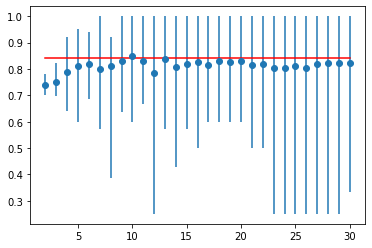

In [9]:
# line plot of k mean values with min/max error bars
pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')

# plot the ideal case in a separate color
pyplot.plot(folds, [ideal for _ in range(len(folds))], color='r')

# show the plot
pyplot.show()

__Results__. The results suggest that for this model on this dataset, most k values underestimate the performance of the model compared to the ideal case. The results suggest that perhaps k=10 alone is slightly optimistic and perhaps k=13 might be a more accurate estimate.

This provides a template that you can use to perform a sensitivity analysis of k values of your chosen model on your dataset against a given ideal test condition.

## 3. Correlation of Test Harness With Target
Once a test harness is chosen, another consideration is how well it matches the ideal test condition across different algorithms.

It is possible that for some algorithms and some configurations, the k-fold cross-validation will be a better approximation of the ideal test condition compared to other algorithms and algorithm configurations.

We can evaluate and report on this relationship explicitly. This can be achieved by calculating how well the k-fold cross-validation results across a range of algorithms match the evaluation of the same algorithms on the ideal test condition.

The [Pearson’s correlation coefficient](https://machinelearningmastery.com/how-to-use-correlation-to-understand-the-relationship-between-variables/) can be calculated between the two groups of scores to measure how closely they match. That is, do they change together in the same ways: when one algorithm looks better than another via k-fold cross-validation, does this hold on the ideal test condition?

We expect to see a strong positive correlation between the scores, such as 0.5 or higher. A low correlation suggests the need to change the k-fold cross-validation test harness to better match the ideal test condition.

__First__, we can define a function that will create a list of standard machine learning models to evaluate via each test harness.

In [10]:
# correlation between test harness and ideal test condition
from numpy import mean
from numpy import isnan
from numpy import asarray
from numpy import polyfit
from scipy.stats import pearsonr
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [11]:
# create the dataset
def get_dataset(n_samples=100):
    X, y = make_classification(n_samples=n_samples, 
                               n_features=20, 
                               n_informative=15, 
                               n_redundant=5, 
                               random_state=1)
    return X, y

In [12]:
# get a list of models to evaluate
def get_models():
    models = list()
    models.append(LogisticRegression())
    models.append(RidgeClassifier())
    models.append(SGDClassifier())
    models.append(PassiveAggressiveClassifier())
    models.append(KNeighborsClassifier())
    models.append(DecisionTreeClassifier())
    models.append(ExtraTreeClassifier())
    models.append(LinearSVC())
    models.append(SVC())
    models.append(GaussianNB())
    models.append(AdaBoostClassifier())
    models.append(BaggingClassifier())
    models.append(RandomForestClassifier())
    models.append(ExtraTreesClassifier())
    models.append(GaussianProcessClassifier())
    models.append(GradientBoostingClassifier())
    models.append(LinearDiscriminantAnalysis())
    models.append(QuadraticDiscriminantAnalysis())
    return models

In [13]:
# evaluate the model using a given test condition
def evaluate_model(cv, model):
    # get the dataset
    X, y = get_dataset()
    
    # evaluate the model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

    # return scores
    return mean(scores)

We will use k=10 for the chosen test harness.

__Second__, enumerate each model and evaluate it using 10-fold cross-validation and our ideal test condition, in this case, LOOCV.

In [14]:
# define test conditions
ideal_cv = LeaveOneOut()
cv = KFold(n_splits=10, shuffle=True, random_state=1)

# get the list of models to consider
models = get_models()

# collect results
ideal_results, cv_results = list(), list()

# evaluate each model
for model in models:
    # evaluate model using each test condition
    cv_mean = evaluate_model(cv, model)
    ideal_mean = evaluate_model(ideal_cv, model)
    
    # check for invalid results
    if isnan(cv_mean) or isnan(ideal_mean):
        continue
    
    # store results
    cv_results.append(cv_mean)
    ideal_results.append(ideal_mean)

    # summarize progress
    print('>%s: ideal=%.3f, cv=%.3f' % (type(model).__name__, ideal_mean, cv_mean))

>LogisticRegression: ideal=0.840, cv=0.850
>RidgeClassifier: ideal=0.830, cv=0.830
>SGDClassifier: ideal=0.760, cv=0.710
>PassiveAggressiveClassifier: ideal=0.730, cv=0.760
>KNeighborsClassifier: ideal=0.760, cv=0.770
>DecisionTreeClassifier: ideal=0.690, cv=0.700
>ExtraTreeClassifier: ideal=0.660, cv=0.590
>LinearSVC: ideal=0.820, cv=0.820
>SVC: ideal=0.900, cv=0.880
>GaussianNB: ideal=0.730, cv=0.720
>AdaBoostClassifier: ideal=0.740, cv=0.740
>BaggingClassifier: ideal=0.770, cv=0.730
>RandomForestClassifier: ideal=0.810, cv=0.790
>ExtraTreesClassifier: ideal=0.830, cv=0.820
>GaussianProcessClassifier: ideal=0.790, cv=0.760
>GradientBoostingClassifier: ideal=0.820, cv=0.810
>LinearDiscriminantAnalysis: ideal=0.830, cv=0.830
>QuadraticDiscriminantAnalysis: ideal=0.550, cv=0.690


Running the example reports the mean classification accuracy for each algorithm calculated via each test harness.

__Comment__. We can see that for some algorithms, the test harness over-estimates the accuracy compared to LOOCV, and in other cases, it under-estimates the accuracy. This is to be expected.


__Third__, calculate the correlation between the mean classification accuracy from the 10-fold cross-validation test harness and the LOOCV test harness.

In [15]:
# calculate the correlation between each test condition
corr, _ = pearsonr(cv_results, ideal_results)
print('Correlation: %.3f' % corr)

Correlation: 0.846


At the end of the run, we can see that the correlation between the two sets of results is reported. In this case, we can see that a correlation of 0.777 is reported, which is a good strong positive correlation. The results suggest that 10-fold cross-validation does provide a good approximation for the LOOCV test harness on this dataset as calculated with 18 popular machine learning algorithms.

__Fourth__, create a scatter plot of the two sets of results and draw a line of best fit to visually see how well they change together.

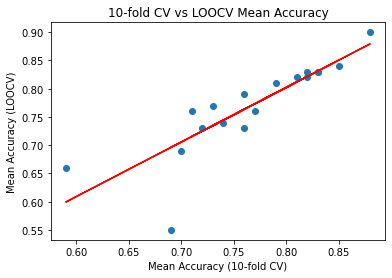

In [16]:
# scatter plot of results
pyplot.scatter(cv_results, ideal_results)

# plot the line of best fit
coeff, bias = polyfit(cv_results, ideal_results, 1)
line = coeff * asarray(cv_results) + bias
pyplot.plot(cv_results, line, color='r')

# label the plot
pyplot.title('10-fold CV vs LOOCV Mean Accuracy')
pyplot.xlabel('Mean Accuracy (10-fold CV)')
pyplot.ylabel('Mean Accuracy (LOOCV)')

# show the plot
pyplot.show()

Finally, a scatter plot is created comparing the distribution of mean accuracy scores for the test harness (x-axis) vs. the accuracy scores via LOOCV (y-axis).

A red line of best fit is drawn through the results showing the strong linear correlation.

This provides a harness for comparing your chosen test harness to an ideal test condition on your own dataset.